In [87]:
## Importing packages

import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
## Reading data
data_raw = pd.read_csv('./algothon21/prices250.txt', delimiter = '\s+', header = None).T

## Adding column names (for each timepoint)
data_raw.columns = ['price' + str(x) for x in range(1, data_raw.shape[1]+1, 1)]

## Adding column representing which instrument
data_raw['instrument'] = ['instrument' + str(x) for x in range(1, data_raw.shape[0]+1, 1)]

## Converting to long format
data = pd.wide_to_long(data_raw, stubnames = 'price', i = 'instrument', j = 'time')
data['instrument'] = [x[0] for x in data.index]
data['time'] = [x[1] for x in data.index]
data.reset_index(drop = True, inplace = True)

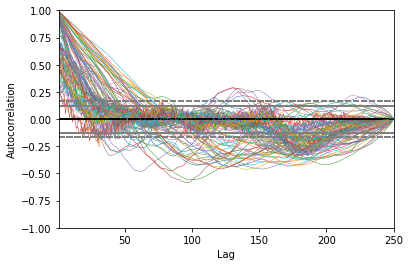

In [151]:
## Autocorrelation graph

for i in range(1, 101, 1):
    instrument = data[data['instrument'] == ('instrument' + str(i))]['price']
    pd.plotting.autocorrelation_plot(instrument, linewidth = 0.5)

## Instrument 1 Subset

In [106]:
## Subset for testing

data_instrument1 = data[data["instrument"] == "instrument1"][["price", "time"]].set_index("time")
data_instrument1.index = pd.to_datetime(data_instrument1.index, unit = 'd')

In [158]:
## Looking for optimal ARIMA parameters

# trainData = data_instrument1["price"][:225]
# testData = data_instrument1["price"][225:]

# p = range(30, 31, 1)
# d = q = range(0, 2)
# pdq = list(itertools.product(p, d, q))
# model_AIC = []

# for paramlist in pdq:
#     arima_model = ARIMA(trainData, order = paramlist)
#     arima_model_fit = arima_model.fit()
#     model_AIC.append(arima_model_fit.aic)

# for i in range(len(model_AIC)):
#     if list(model_AIC == min(model_AIC))[i] == True:
#         print(pdq[i])

/Users/alanburzevski/Documents/Uni/casecomp/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/alanburzevski/Documents/Uni/casecomp/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/alanburzevski/Documents/Uni/casecomp/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/alanburzevski/Documents/Uni/casecomp/venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood opti

/Users/alanburzevski/Documents/Uni/casecomp/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/alanburzevski/Documents/Uni/casecomp/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/alanburzevski/Documents/Uni/casecomp/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='time'>

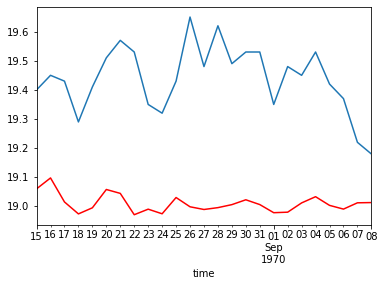

In [160]:
## Training using optimised parameters

trainData = data_instrument1["price"][:225]
testData = data_instrument1["price"][225:]
arima_model = ARIMA(trainData, order = (30, 1, 0))
arima_model_fit = arima_model.fit()
predictions = arima_model_fit.forecast(steps = 25)

testData.plot()
predictions.plot(color = "red")